
<br>
Example usage of DMF fMRI simulator.<br>
Pedro Mediano, June 2020<br>


In [2]:
import fastdyn_fic_dmf as dmf
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


Run simulation for a given nb of steps (milliseconds)

## Homeostatic grid seacrch


In [38]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
brunout = 5
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
params['seed'] = 2
G_max = 6
DECAY_max = 60000
OBJ_RATE_max = 15
#G_step = 0.1
#DECAY_step = 0.2
G_step = 2
DECAY_step = 20000
OBJ_RATE_step = 3
G_range = np.arange(0,G_max,G_step)
DECAY_range = [100,10000,60000]#np.arange(1,DECAY_max,DECAY_step)
OBJ_RATE_range = np.arange(1,OBJ_RATE_max,OBJ_RATE_step)
amount_slow_regions_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
mean_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
std_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
homeostatic_fittness_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
rates_grid,rates_inh_grid, bold_grid, fic_t_grid = np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps))
for idx_G,G in enumerate(G_range):
    for idx_DECAY,DECAY in enumerate(DECAY_range):
        for idx_OBJ_RATE,OBJ_RATE in enumerate(OBJ_RATE_range):
            params['G'] = G
            params['taoj'] = DECAY
            params['obj_rate'] = OBJ_RATE
            #params['taoj'] = 210000
            params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
            N = C.shape[0]
            tracemalloc.start()
            rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True)
            rates_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = rates
            rates_inh_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = rates_inh
            #bold_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = bold
            fic_t_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = fic_t
            # Slicing and computations
            bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
            rates = rates[:, np.ceil(brunout * 1000).astype(int):]
            rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
            fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
            sampling_freq = 10000  
            power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
            plow_ptot = np.sum(power_spectrum[:, :39], axis=1)/np.sum(power_spectrum[:,:], axis=1)
            amount_slow_regions = np.sum(plow_ptot>0.3)
            mean_slow = np.mean(plow_ptot)
            std_slow = np.std(plow_ptot)
            homeostatic_fittness =  OBJ_RATE - np.mean(rates)  #if not np.isnan(np.mean(rates)) else 0
            amount_slow_regions_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = amount_slow_regions
            mean_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = mean_slow
            std_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = std_slow
            homeostatic_fittness_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = homeostatic_fittness

Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation     Using multitaper spectrum estimation with 30 D

In [42]:
homeostatic_fittness_grid

array([[[ -39.17410304,  -36.18033135,  -33.18655994,  -30.19278881,
          -27.19901796],
        [ -30.74435046,  -28.20360634,  -25.66503995,  -23.12858897,
          -20.59419306],
        [ -12.63528691,  -10.55909975,   -8.51737116,   -6.50679454,
           -4.52438868]],

       [[ -91.46734599,  -88.47404053,  -85.48073516,  -82.48742989,
          -79.4941247 ],
        [ -72.40725223,  -69.90914234,  -67.41174097,  -64.91503858,
          -62.41902576],
        [ -35.0151812 ,  -33.19549391,  -31.38443257,  -29.58154378,
          -27.78637989]],

       [[-142.69623824, -139.70314581, -136.71005342, -133.71696108,
         -130.72386879],
        [-112.73084564, -110.25158283, -107.77271262, -105.29423078,
         -102.8161333 ],
        [ -55.9756821 ,  -54.22591059,  -52.4808417 ,  -50.74027931,
          -49.00404014]]])

In [46]:
homeostatic_fittness_grid.shape

(3, 3, 5)

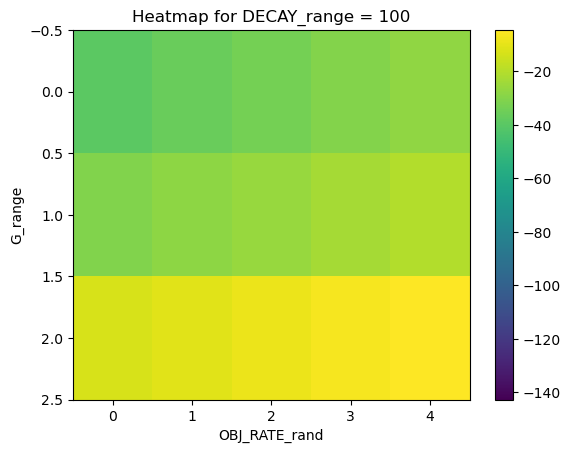

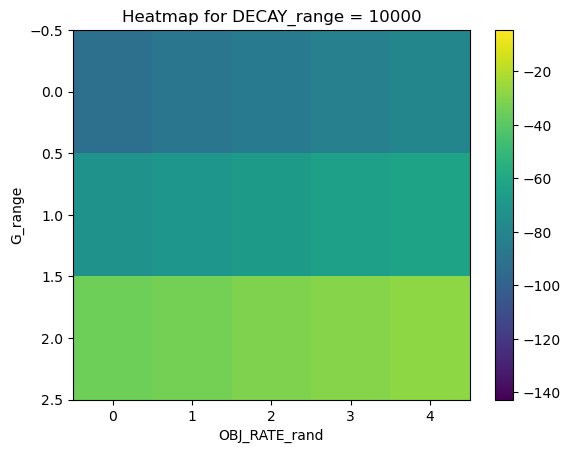

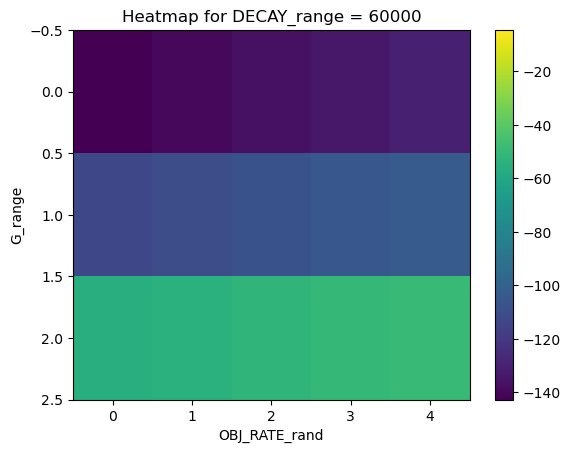

In [48]:
import matplotlib.pyplot as plt

for i, decay_value in enumerate(DECAY_range):
    fig, ax = plt.subplots()
    
    # Extracting the corresponding slice from homeostatic_fittness_grid
    slice_data = homeostatic_fittness_grid[i]
    
    # Plotting the heatmap
    heatmap = ax.imshow(slice_data, cmap='viridis', aspect='auto', vmin=np.min(homeostatic_fittness_grid), vmax=np.max(homeostatic_fittness_grid))
    plt.colorbar(heatmap, ax=ax)
    
    ax.set_xlabel('OBJ_RATE_rand')
    ax.set_ylabel('G_range')
    ax.set_title(f'Heatmap for DECAY_range = {decay_value}')
    
    plt.show()


In [50]:
homeostatic_fittness_grid[0,0,0]

-39.17410304378568

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


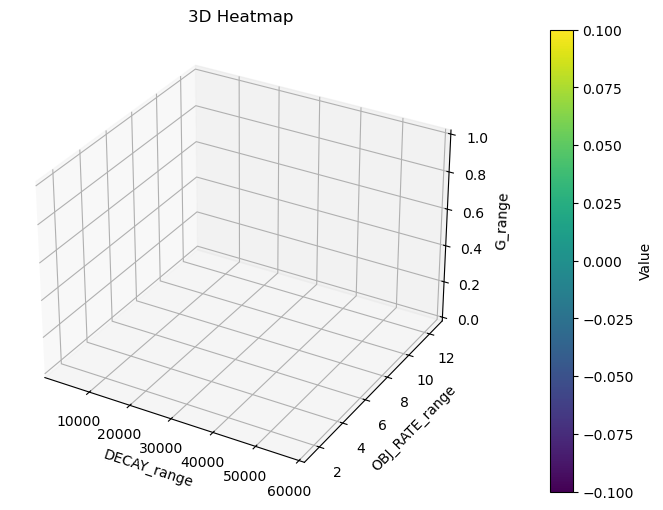

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming homeostatic_fittness_grid contains the values
# and DECAY_range, OBJ_RATE_range, and G_range are your range variables

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Creating meshgrid for X, Y, Z axes
X, Y = np.meshgrid(DECAY_range, OBJ_RATE_range)
Z = homeostatic_fittness_grid

# Plotting the 3D heatmap
heatmap = ax.imshow(Z.T, cmap='viridis', aspect='auto', extent=[min(DECAY_range), max(DECAY_range), min(OBJ_RATE_range), max(OBJ_RATE_range)])
ax.set_xlabel('DECAY_range')
ax.set_ylabel('OBJ_RATE_range')
ax.set_zlabel('G_range')
ax.set_title('3D Heatmap')

# Adding colorbar
cbar = fig.colorbar(heatmap, ax=ax, pad=0.1)
cbar.set_label('Value')

plt.show()


## Gridsearch

In [ ]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
N = C.shape[0]
brunout = 5
params = dmf.default_params(C=C)
params['seed'] = 2
G_max = 15
LR_max = 15
#G_step = 0.1
#LR_step = 0.2
G_step = 5
LR_step = 10
G_range = np.arange(0,G_max,G_step)
LR_range = np.arange(0,LR_max,LR_step)
amount_slow_regions_grid = np.zeros((len(G_range), len(LR_range)))
mean_slow_grid = np.zeros((len(G_range), len(LR_range)))
std_slow_grid = np.zeros((len(G_range), len(LR_range)))
rates_grid,rates_inh_grid, bold_grid, fic_t_grid = np.zeros((len(G_range),len(LR_range),N,nb_steps)),np.zeros((len(G_range),len(LR_range),N,nb_steps)),np.zeros((len(G_range),len(LR_range),N,nb_steps)),np.zeros((len(G_range),len(LR_range),N,nb_steps))
for idx_G,G in enumerate(G_range):
    for idx_LR,LR in enumerate(LR_range):
        params['G'] = G
        params['lrj'] = LR
        params['taoj'] = 60000
        params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
        N = C.shape[0]
        tracemalloc.start()
        rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True)
        rates_grid[idx_G, idx_LR] = rates
        rates_inh_grid[idx_G, idx_LR] = rates_inh
        #bold_grid[idx_G, idx_LR] = bold
        fic_t_grid[idx_G, idx_LR] = fic_t
        # Slicing and computations
        bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
        rates = rates[:, np.ceil(brunout * 1000).astype(int):]
        rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
        fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
        sampling_freq = 10000  
        power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
        plow_ptot = np.sum(power_spectrum[:, :39], axis=1)/np.sum(power_spectrum[:,:], axis=1)
        amount_slow_regions = np.sum(plow_ptot>0.3)
        mean_slow = np.mean(plow_ptot)
        std_slow = np.std(plow_ptot)
        amount_slow_regions_grid[idx_G, idx_LR] = amount_slow_regions
        mean_slow_grid[idx_G, idx_LR] = mean_slow
        std_slow_grid[idx_G, idx_LR] = std_slow

In [60]:
bold = bold_grid[0,0,0]
rates = rates_grid[0,0,0]
rates_inh = rates_inh_grid[0,0,0]
fic_t = fic_t_grid[0,0,0]

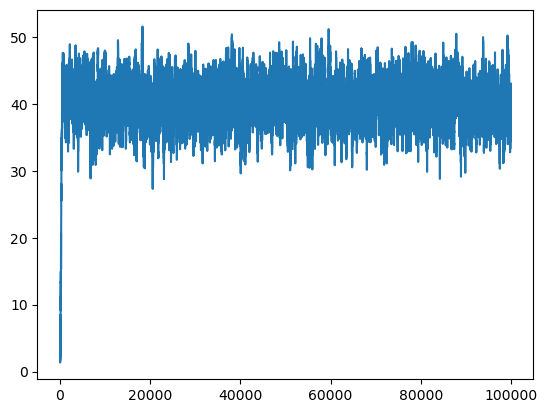

In [62]:
plt.plot(rates[0, :])

In [57]:

brunout = 5
# Slicing and computations
bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)


# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))

fig = plt.figure(figsize=(15, 9))
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj']}")
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.001, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.semilogy(frequencies, power_spectrum[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[0, :39])/np.sum(power_spectrum[0,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()


(4005, 99966)
(99997, 90)
(31, 90)


/Users/ivanmindlin/miniforge3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


KeyboardInterrupt: 

## One run

In [65]:
DECAY_range

[100, 10000, 60000]

Calling run
Ending beautiful simulation has option 2 (4005, 16)
(47, 90)
(31, 90)
    Using multitaper spectrum estimation with 30 DPSS windows


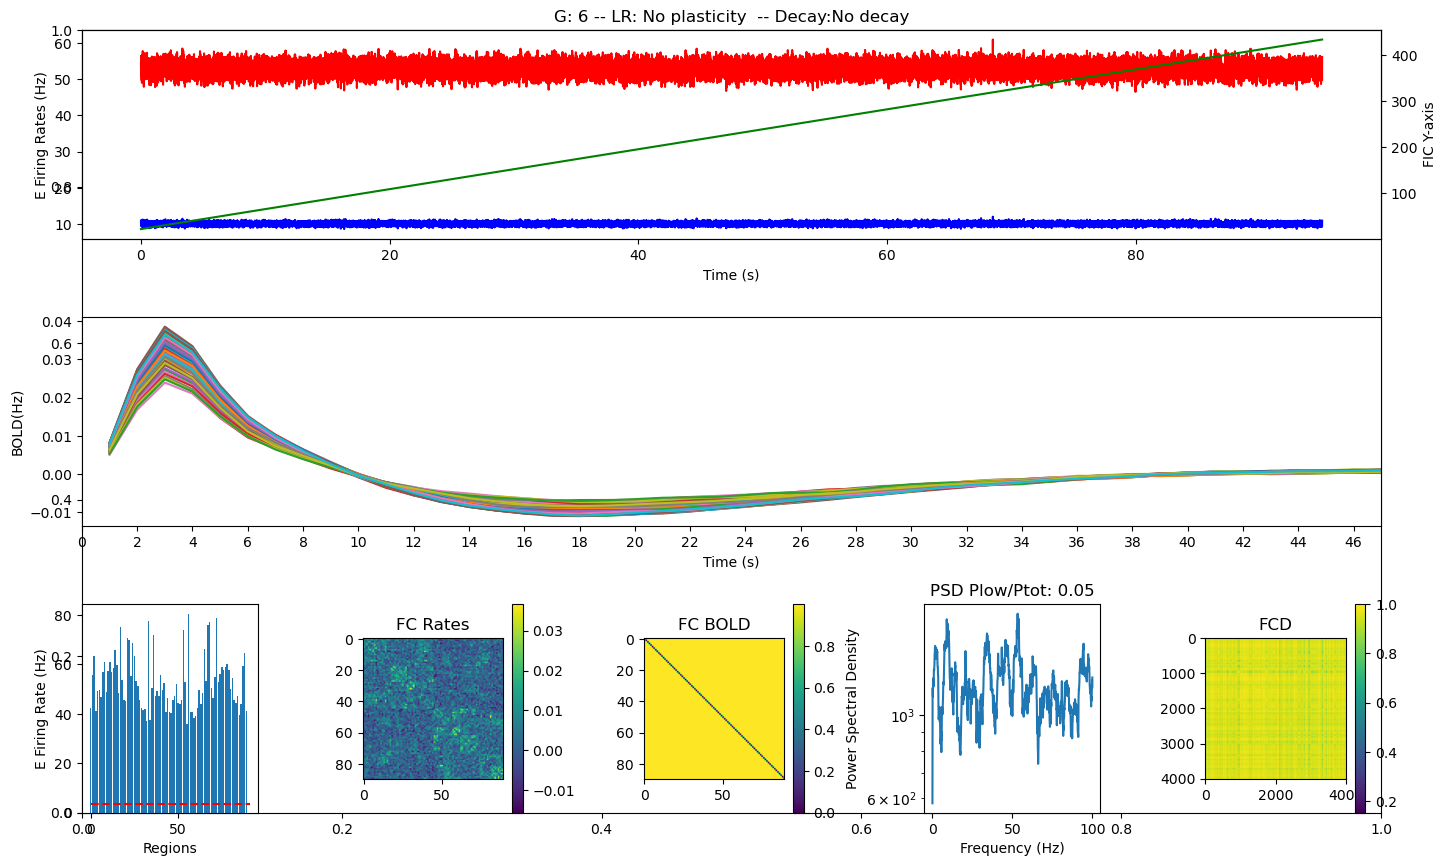

In [4]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['seed'] = 2
params['G'] = 6
params['lrj'] = 8
params['obj_rate'] = 3.4
params['taoj'] = 210000
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]
tracemalloc.start()
with_decay = False
with_plasticity = False
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)
# displaying the memory

brunout = 5
# Slicing and computations
bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)


# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))

fig = plt.figure(figsize=(15, 9))
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.001, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.semilogy(frequencies, power_spectrum[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[0, :39])/np.sum(power_spectrum[0,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()


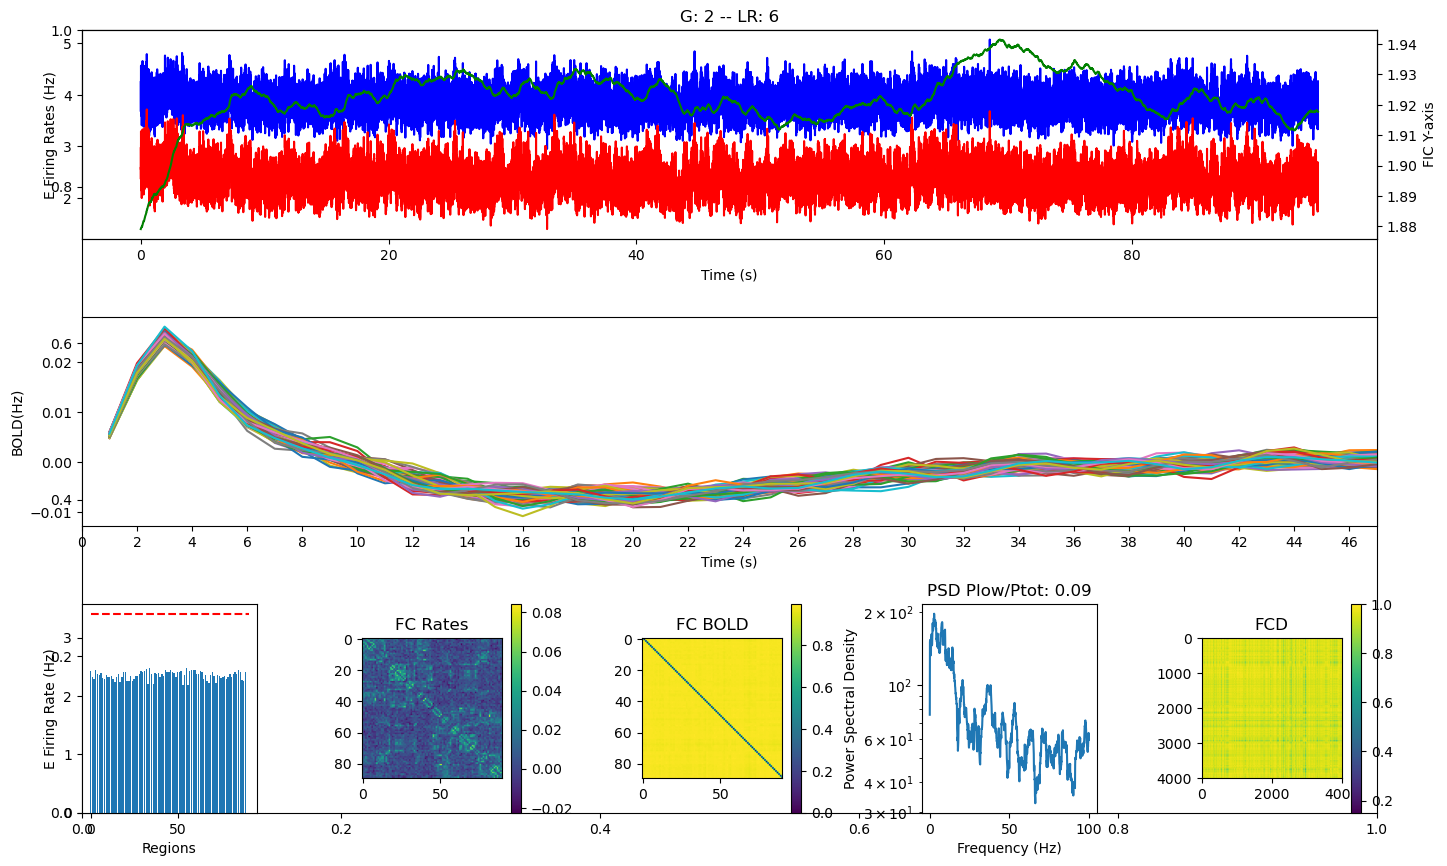

In [64]:
fig = plt.figure(figsize=(15, 9))
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj']}")
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.001, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.semilogy(frequencies, power_spectrum[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[0, :39])/np.sum(power_spectrum[0,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates_grid[2,0][:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh_grid[2,0][:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t_grid[2,0][:, np.ceil(brunout * 1000).astype(int):]

In [ ]:
# Plotting the heatmap for amount_slow_regions
plt.figure(figsize=(12, 4))
# Plotting the heatmap for amount_slow_regions
plt.subplot(1, 3, 1)
plt.imshow(amount_slow_regions_grid, cmap='viridis', aspect='auto')
plt.title('Amount of Slow Regions')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.xlabel('LR')

# Plotting the heatmap for mean_slow
plt.subplot(1, 3, 2)
plt.imshow(mean_slow_grid, cmap='plasma', aspect='auto')
plt.title('Mean Slow')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.xlabel('LR')

# Plotting the heatmap for std_slow
plt.subplot(1, 3, 3)
plt.imshow(std_slow_grid, cmap='inferno', aspect='auto')
plt.title('Standard Deviation Slow')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.xlabel('LR')

plt.tight_layout()
plt.show()
